In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import pandas as pd
import torchvision.models as models 
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import matplotlib.pyplot as plt
import latent_plot as lp
from torch.autograd import Variable
from torch.optim import lr_scheduler
import seaborn as sns
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import copy
#from model import VAE

import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from data_loader import *
from model import convVAE
from sklearn.manifold import TSNE

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
csv_path = '/home/vip/sayan-mandal/datasets/ohts/progress_subset.csv'
img_path = '/home/vip/sayan-mandal/datasets/ohts/cropped_256'

ResizeParam = 128
batch_size = 72
FD = ProgressionDataLoader(csv_path, img_path,transform=transforms.Compose([transforms.Resize(ResizeParam),transforms.RandomHorizontalFlip(p=1), transforms.ToTensor()]))
data_loader = torch.utils.data.DataLoader(FD, batch_size = batch_size)

In [4]:
#vae model structure
nl = 2048
model = convVAE((3,128,128),nl).cuda()
model.load_state_dict(torch.load('/home/vip/sayan-mandal/vae-convmodels/dfcvae_inp128_nl'+str(nl)+'_a1b1.torch'))
print(model)

convVAE(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(64, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Sequential(
    (0): Linear(in_features=16384, out_features=4096, bias=True)
    (1): BatchNo

In [5]:
#Utility functions to un-normalize and display an image
def imshow(img):
    #img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0))) 

#Define the image classes
classes = ['normal','glaucoma','suspect']

#Obtain one batch of training images
dataiter = iter(data_loader)
data, labels, time, idxs = dataiter.next()
data = data[idxs == 7]
labels = labels[idxs == 7]
time = time[idxs == 7]
idxs = idxs[idxs == 7]
model.eval()
images,_,_ = model(Variable(data).cuda())
images = images.detach().cpu().numpy() # convert images to numpy for display

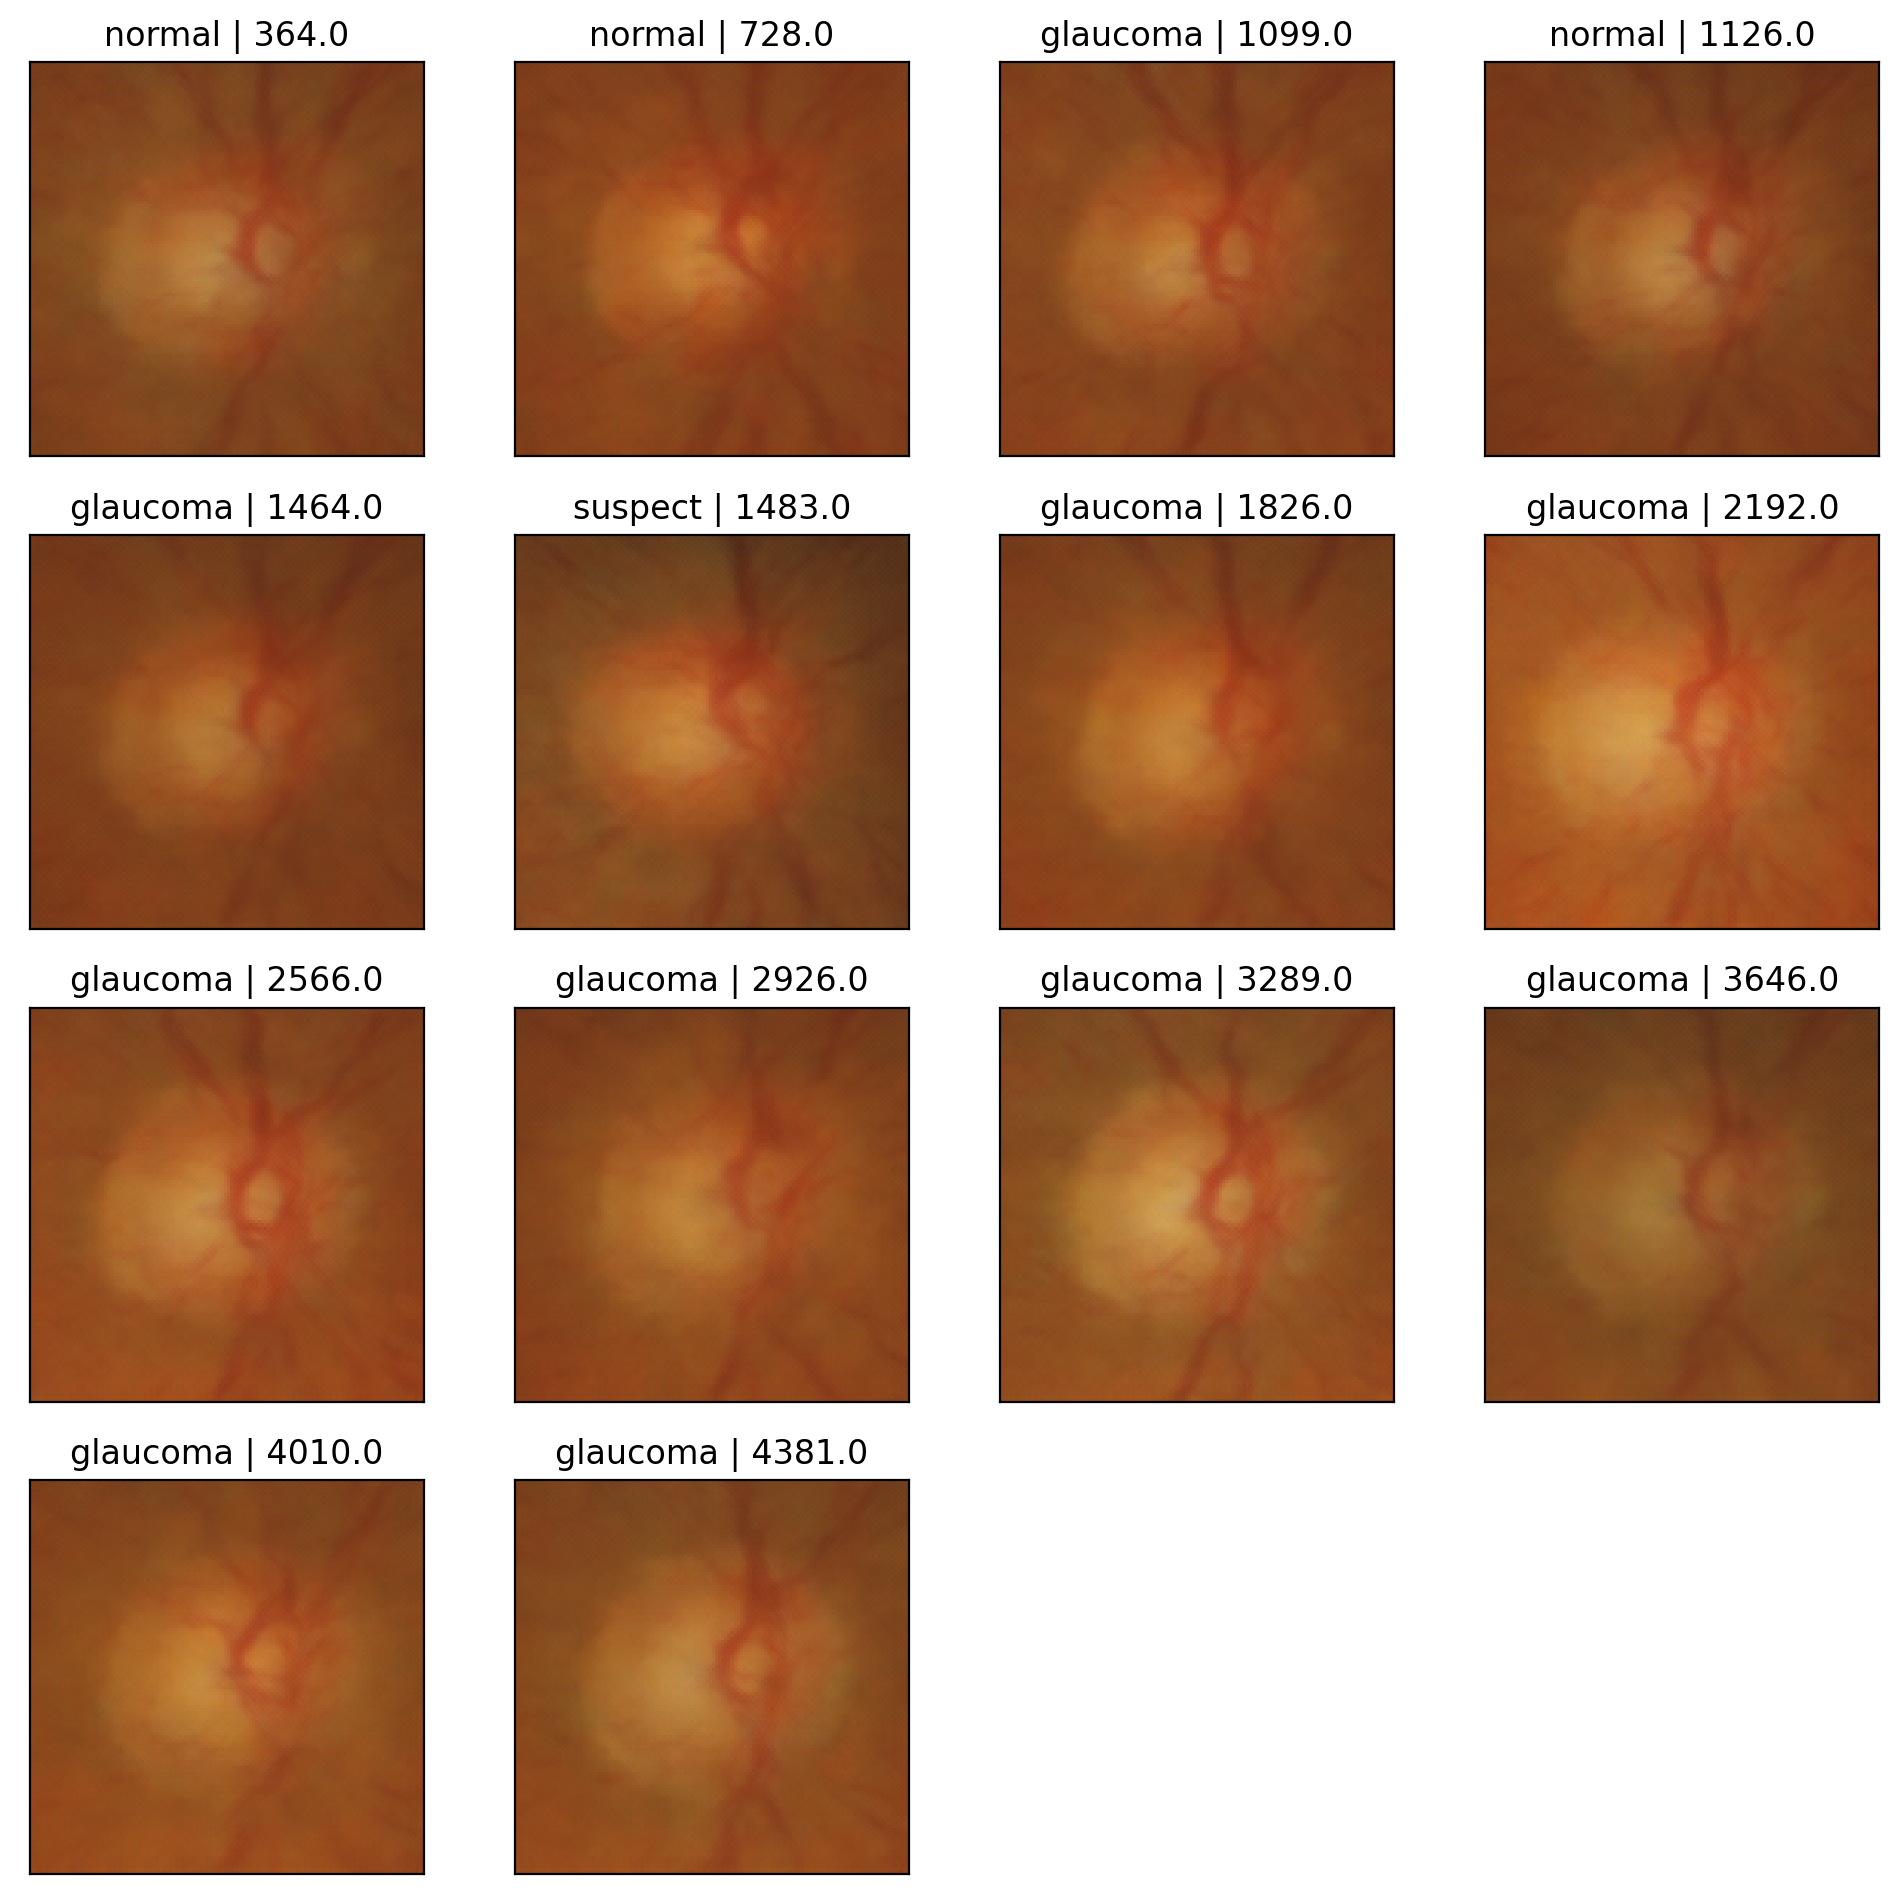

In [6]:
#Plot the images
fig = plt.figure(figsize=(12, 12))
# display 20 images
idx = 0
while idx < images.shape[0]:
    ax = fig.add_subplot(4,4, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]]+" | "+str(time[idx].item()))
    idx+=1

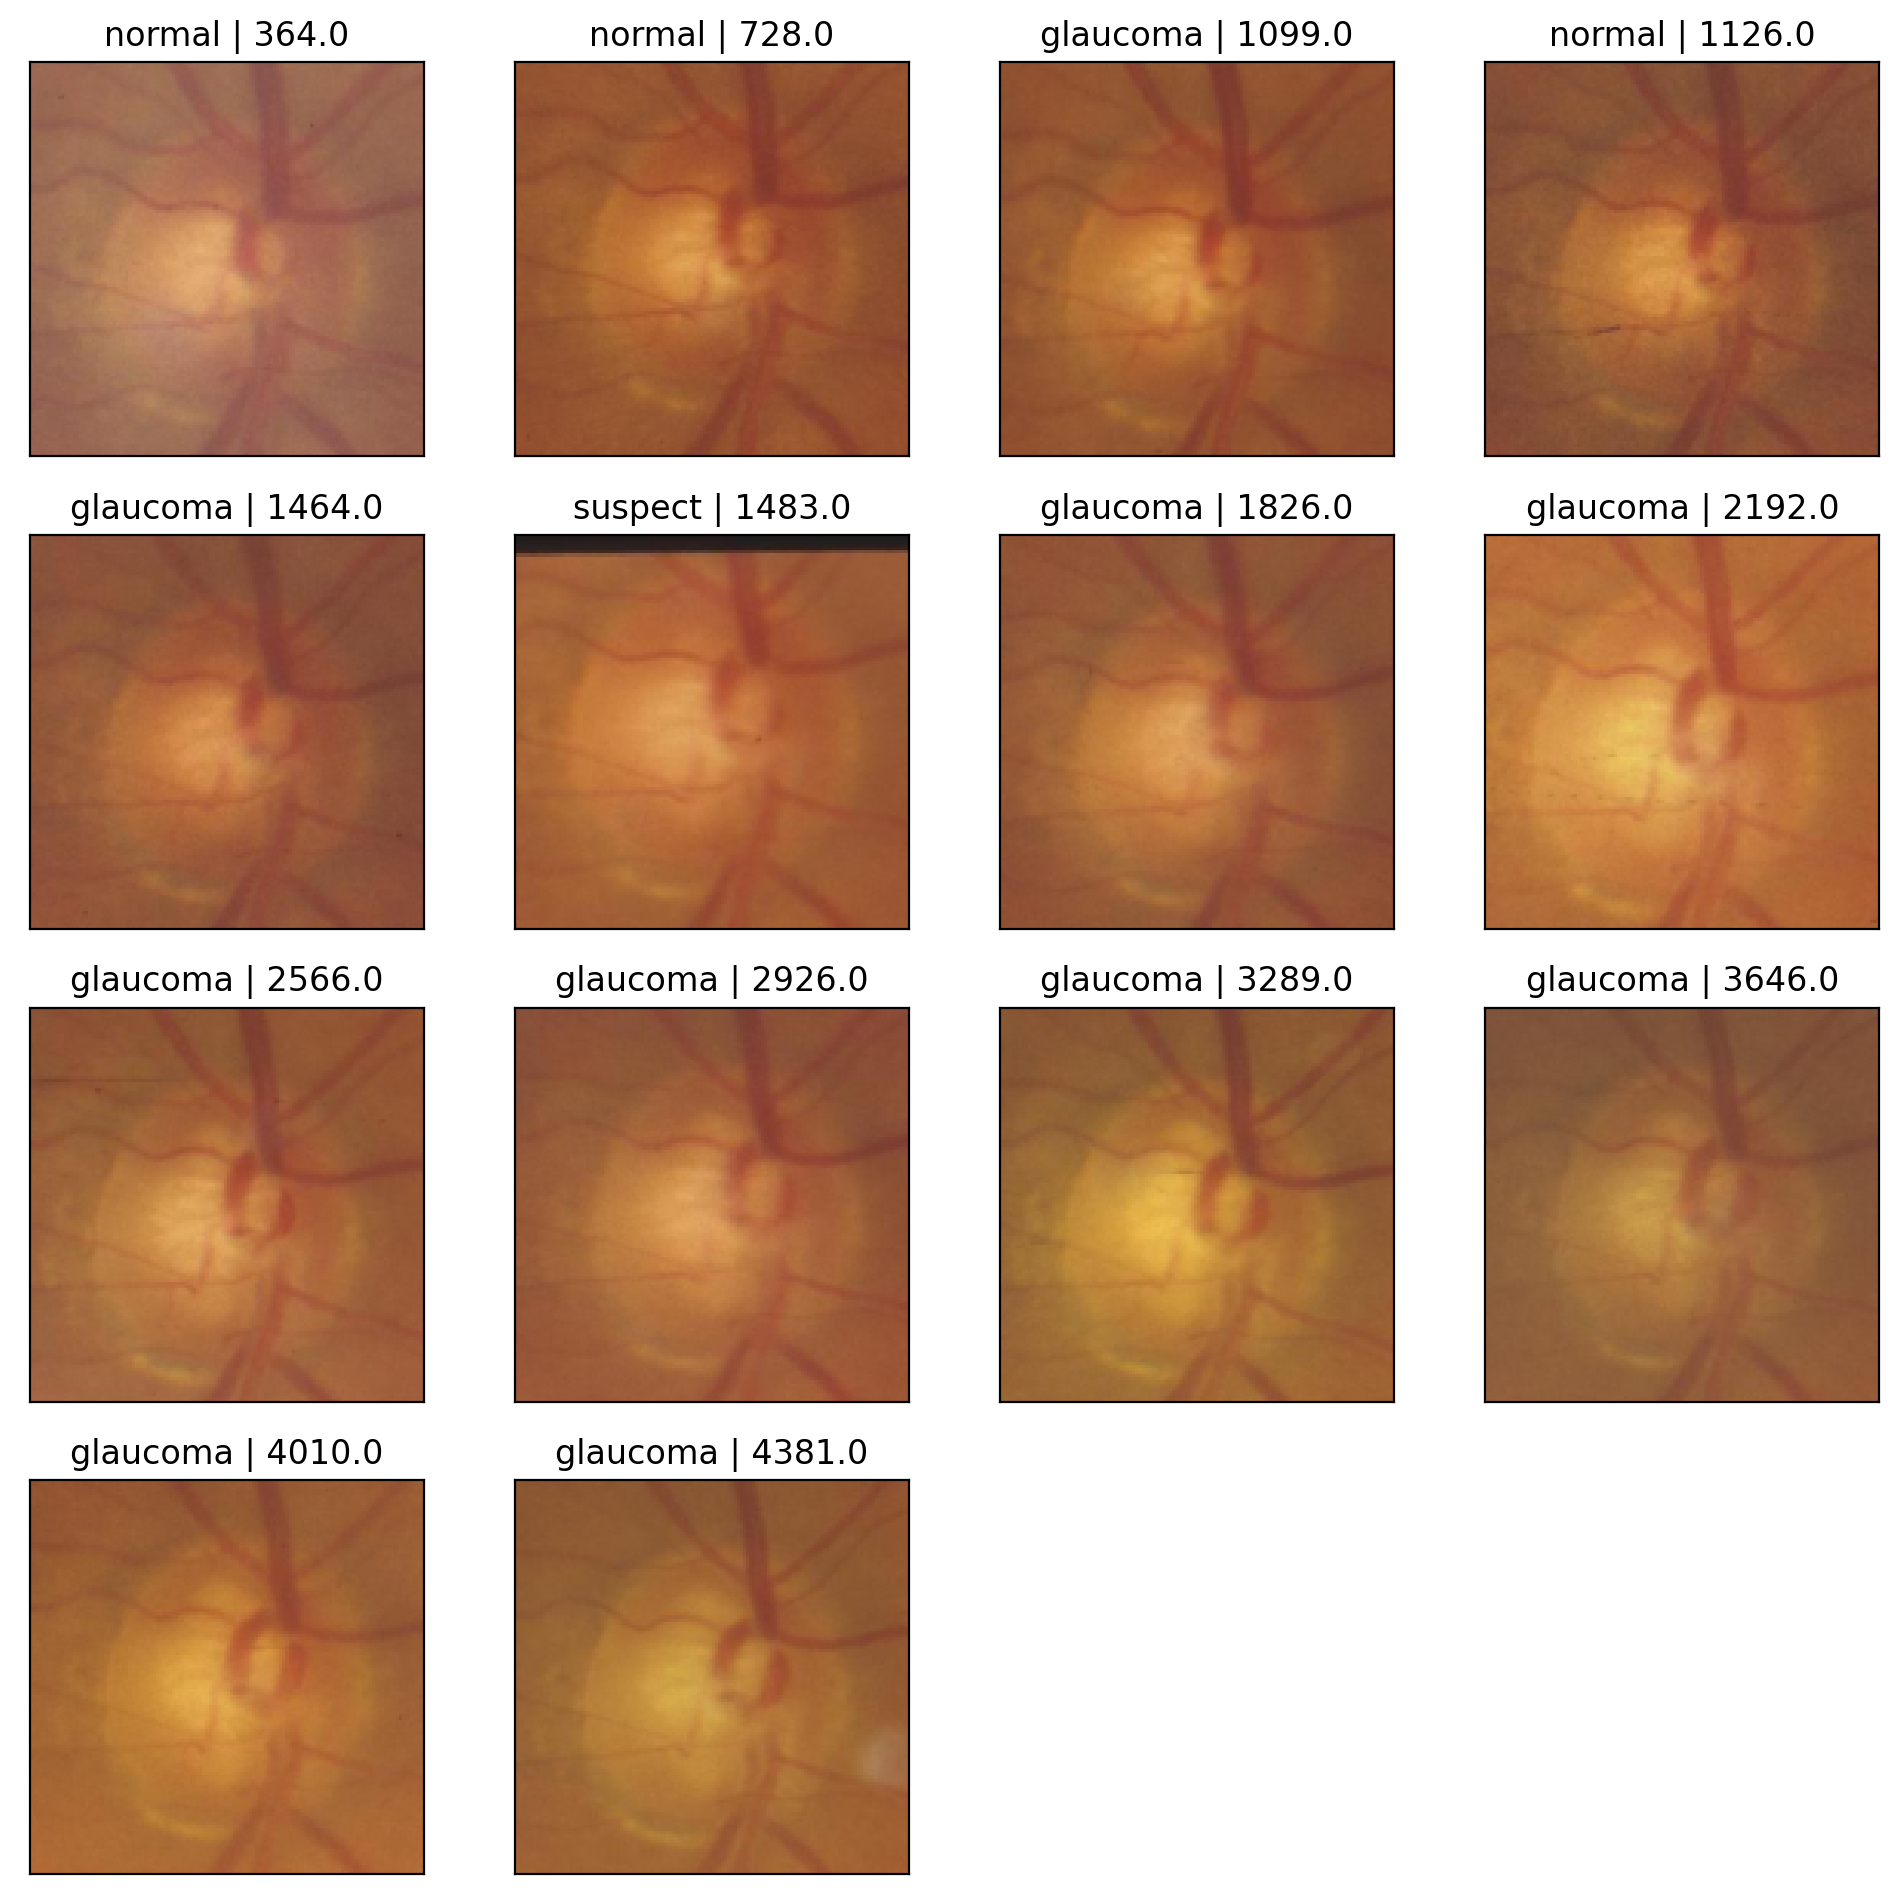

In [7]:
#Plot the images
fig = plt.figure(figsize=(12, 12))
# display 20 images
idx = 0
while idx < images.shape[0]:
    ax = fig.add_subplot(4,4, idx+1, xticks=[], yticks=[])
    imshow(data[idx])
    ax.set_title(classes[labels[idx]]+" | "+str(time[idx].item()))
    idx+=1

In [10]:
df

Unnamed: 0      nl  sim_mean   sim_std   sim_max   sim_min         loss  \
0            0     2.0  0.862567  0.060706  0.971383  0.492038  1568.526420   
1            1     4.0  0.862547  0.060980  0.977732  0.560586  1508.350514   
2            2     8.0  0.877966  0.056428  0.979862  0.530230  1451.204730   
3            3    16.0  0.878630  0.058073  0.981657  0.352533  1426.873021   
4            4    32.0  0.887842  0.052996  0.983372  0.581763  1338.107903   
5            5    64.0  0.895557  0.057135  0.983405  0.451275  1238.696235   
6            6   128.0  0.905886  0.055791  0.982271  0.138676  1173.198742   
7            7   256.0  0.913770  0.052212  0.981637  0.249297  1055.118190   
8            8   512.0  0.910659  0.070907  0.977272  0.048678   985.765699   
9            9  1024.0  0.917291  0.060036  0.984928  0.076426  1001.271127   
10          10  2048.0  0.924978  0.052515  0.988435  0.415603   962.543744   
11          11  2048.0  0.919994  0.083574  0.988314  0.028440   999.108483   
12          12  2048.0  0.918054  0.063091  0.986335  0.346697   995.371913   
13          13  4096.0  0.919977  0.048373  0.987512  0.640450  2033.860192   

            bce        kld  
0   1568.491627   0.034805  
1   1508.329866   0.020644  
2   1451.109983   0.094753  
3   1426.589056   0.283971  
4   1337.825192   0.282705  
5   1237.531877   1.164355  
6   1172.586588   0.612154  
7   1053.954919   1.163269  
8    982.455063   3.310631  
9    998.039388   3.231746  
10   961.063651   1.480090  
11   993.304159   5.804327  
12   992.184838   3.187076  
13  2017.818504  16.041685

In [8]:
def show_difference(before = data, after = images, labels = labels,idx = 0):
    label = labels[idx]
    before = before.numpy()[idx].transpose((1,2,0))
    after = after[idx].transpose((1,2,0))
    classes = ['normal', 'glaucoma']

    before_gray = cv2.cvtColor(before, cv2.COLOR_RGB2GRAY)
    after_gray = cv2.cvtColor(after, cv2.COLOR_RGB2GRAY)

    (score, diff) = structural_similarity(before_gray, after_gray, full=True)
    before = (before*255).astype('uint8')
    diff = (diff*255).astype('uint8')
    after = (after*255).astype('uint8')
    thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]

    mask = np.zeros(before.shape, dtype='uint8')
    filled_after = after.copy()

    for c in contours:
        area = cv2.contourArea(c)
        if area < 3000 and area > 30:
            cv2.drawContours(filled_after, [c], 0, (220,220,220), 1)#thickness = cv2.FILLED)
    fig = plt.figure(figsize=(6, 3.2))
    ax = fig.add_subplot(1,2, 1, xticks=[], yticks=[])
    plt.imshow(before)
    ax.set_title("Original: " + classes[label])
    ax = fig.add_subplot(1,2, 2, xticks=[], yticks=[])
    plt.imshow(filled_after)
    ax.set_title("Reconstruction: " + classes[label])
    plt.suptitle("Image similarity score: " + str(score))
    plt.show()

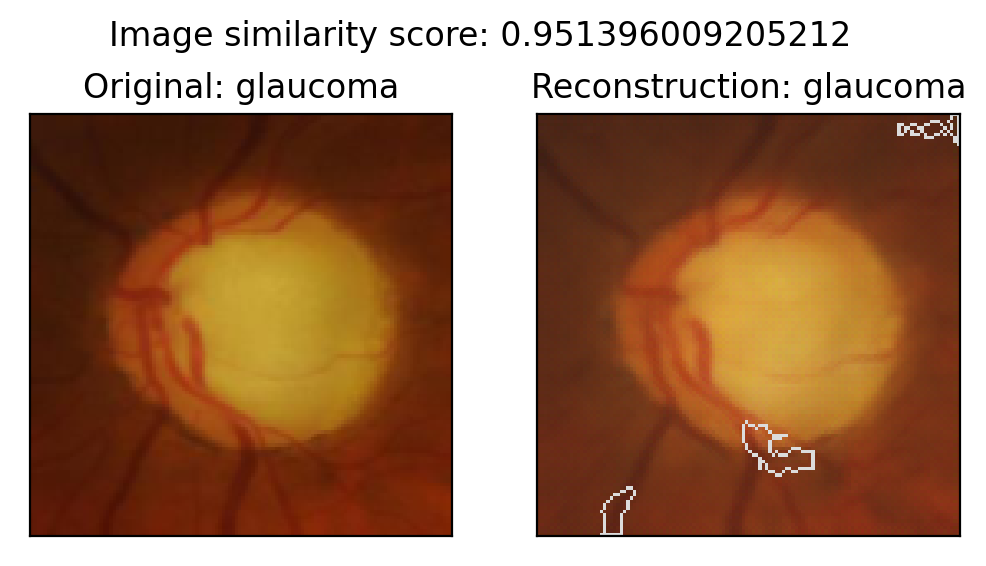

In [115]:
show_difference(idx = 29)

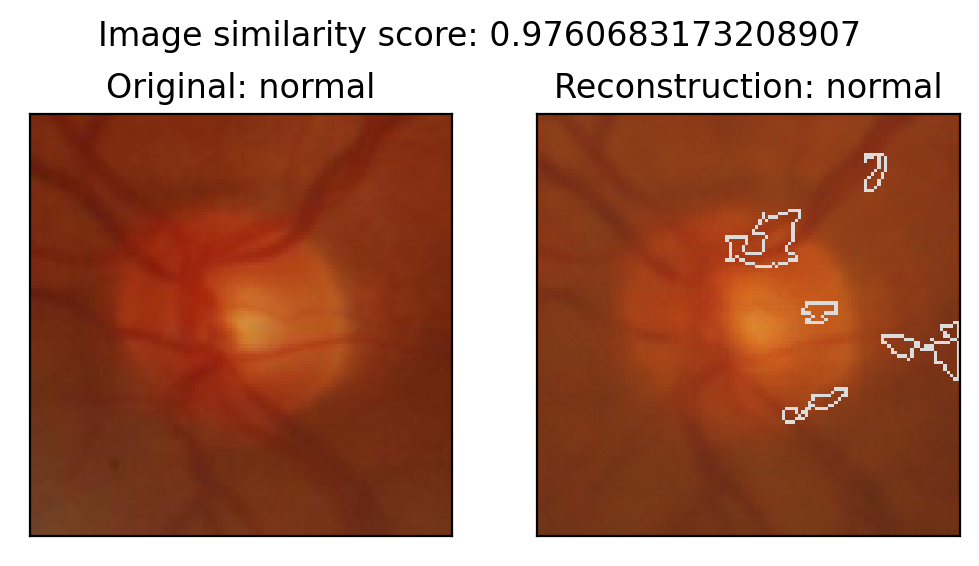

In [116]:
show_difference(idx = 1)

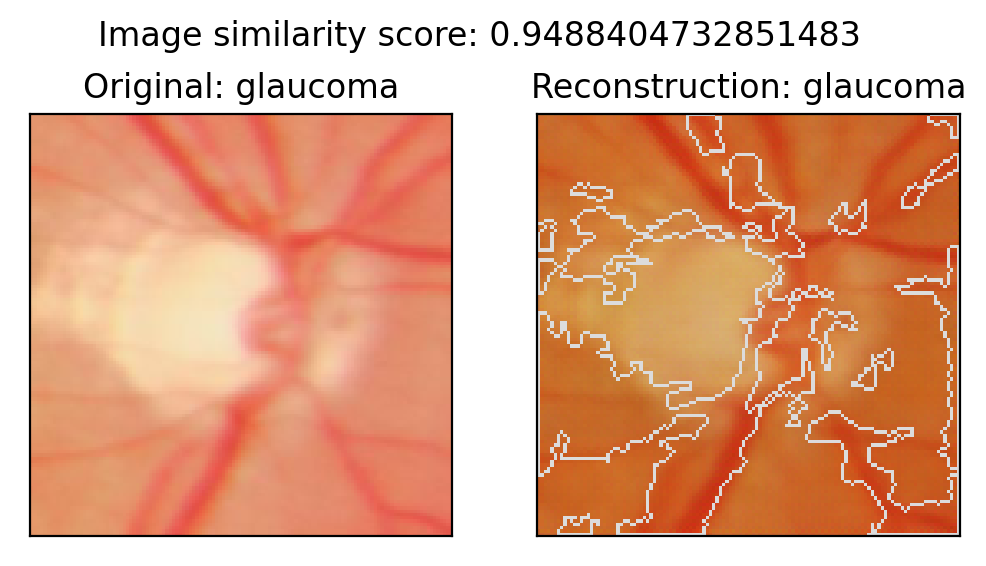

In [117]:
show_difference(idx = 4)

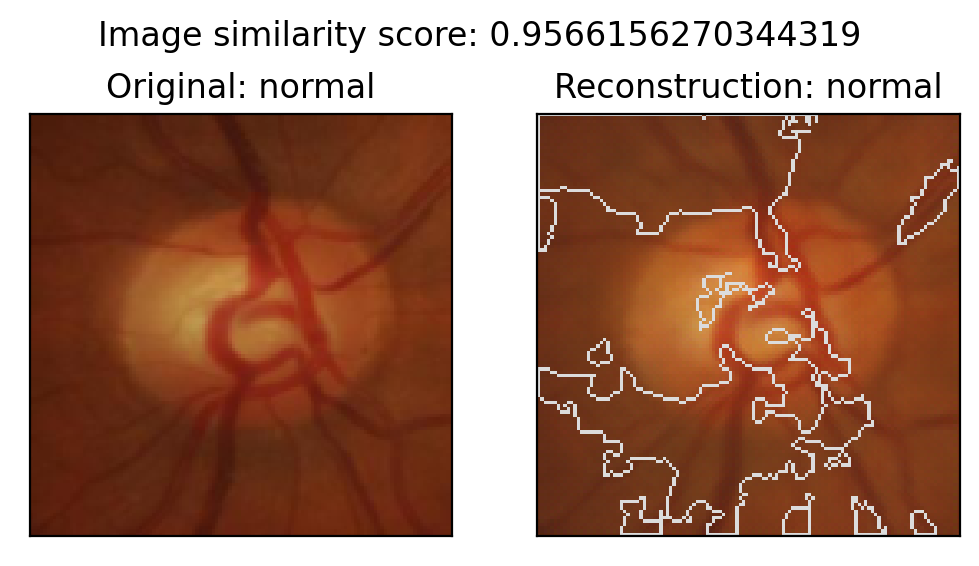

In [118]:
show_difference(idx = 55)

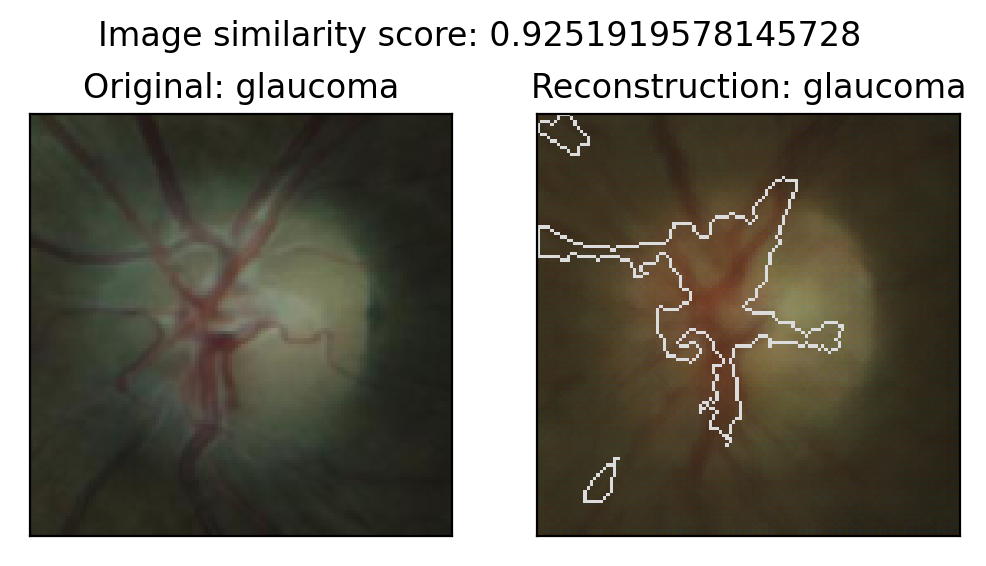

In [119]:
show_difference(idx = 60)

In [18]:
from sklearn.manifold import TSNE

n_comp = 2
perplexity = 30

In [25]:

for i, (data,label) in enumerate(data_loader):
    y, _,_ =  model.encode(Variable(data).cuda())
    y = y.cpu().detach().numpy()
    if i == 0:
        yd = y
        lbl = label.numpy()
    else:
        yd = np.append(yd,y,axis=0)
        lbl = np.append(lbl,label.numpy(), axis=0)

In [27]:
y_embed = TSNE(n_components=2).fit_transform(yd)
#labels = ['normal','glaucoma']

0
1


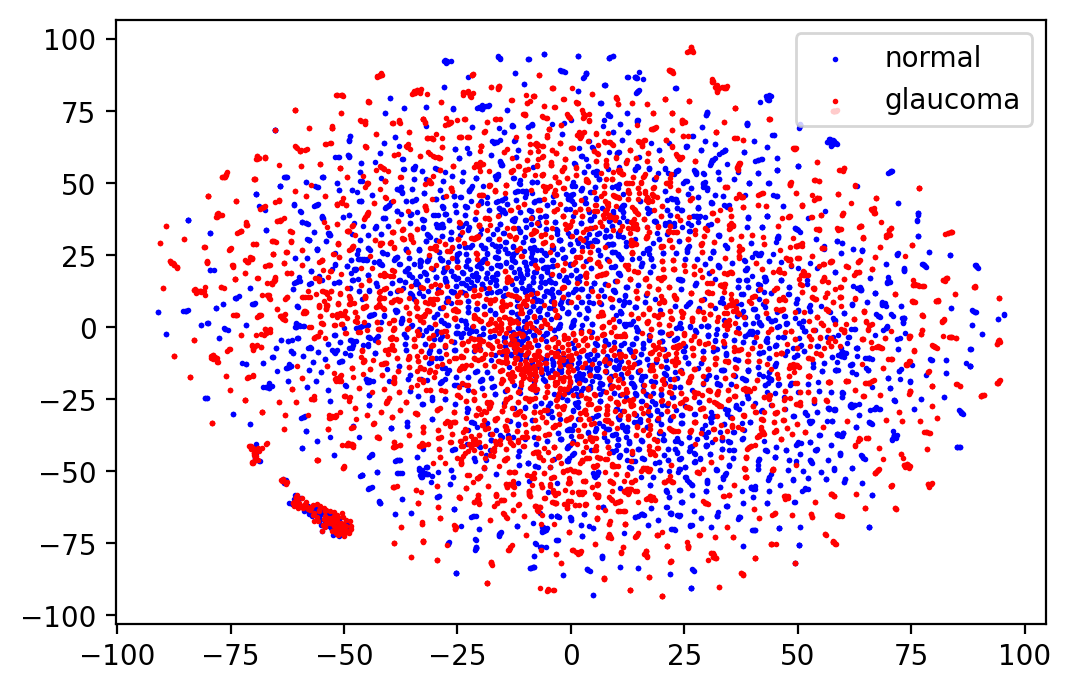

In [28]:
fig, ax = plt.subplots()
cdict = {0: 'blue', 1: 'red'}
for g in np.unique(lbl):
    print(g)
    idx = np.where(lbl == g)
    ax.scatter(y_embed[idx,0],y_embed[idx,1],c=cdict[g], label = classes[g], s = 1, alpha = 1)
ax.legend()
plt.show()

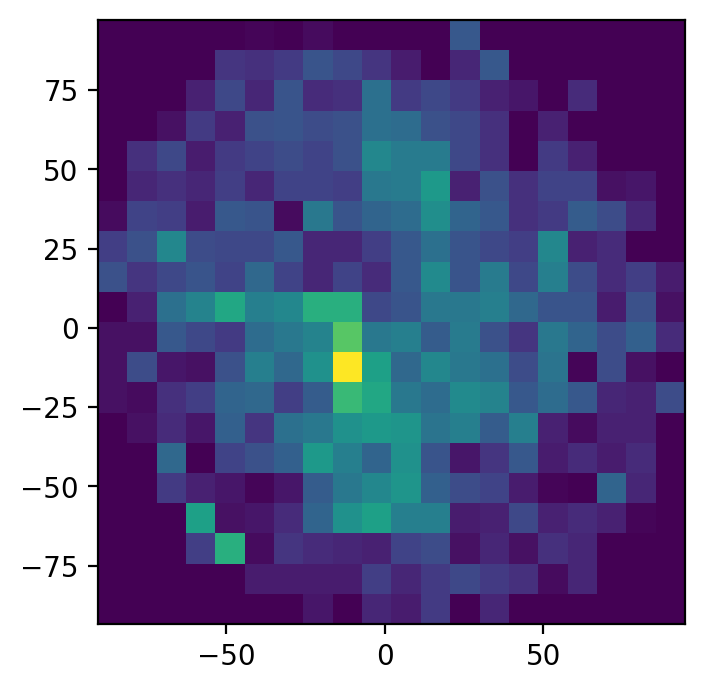

In [32]:
idx = np.where(lbl == 1)
heatmap, xedges, yedges = np.histogram2d(y_embed[idx,0].flatten(),y_embed[idx,1].flatten(),bins=20)
extent = [xedges[0],xedges[-1],yedges[0],yedges[-1]]
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

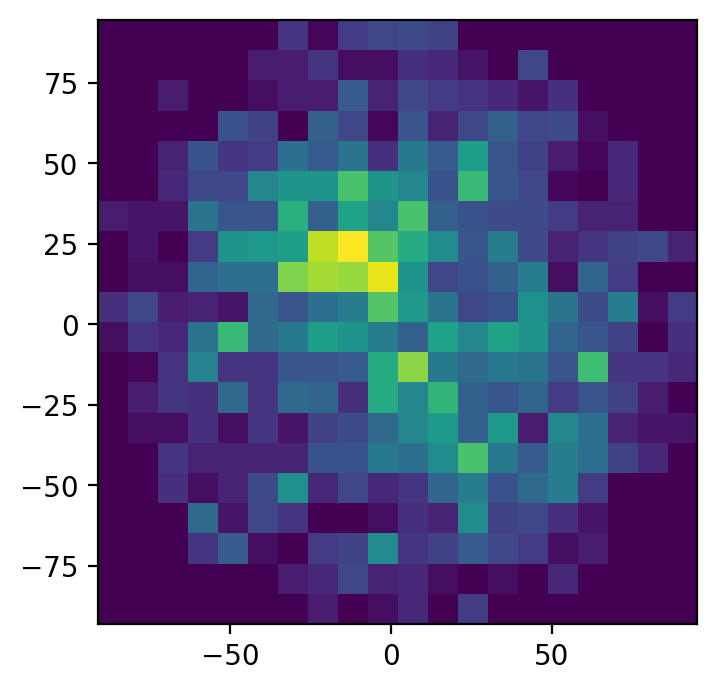

In [31]:
idx = np.where(lbl == 0)
heatmap, xedges, yedges = np.histogram2d(y_embed[idx,0].flatten(),y_embed[idx,1].flatten(), bins=20)
extent = [xedges[0],xedges[-1],yedges[0],yedges[-1]]
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

In [138]:
def gethistogram(features, label,idx,kde = False):
    classes = ['normal','glaucoma']
    fig = plt.figure(figsize=(4,3))
    sns.histplot(features[idx],kde = kde, element='step')
    plt.xlabel('Latent feature')
    plt.ylabel('Frequency')
    plt.title(classes[label[idx]])
    plt.show()

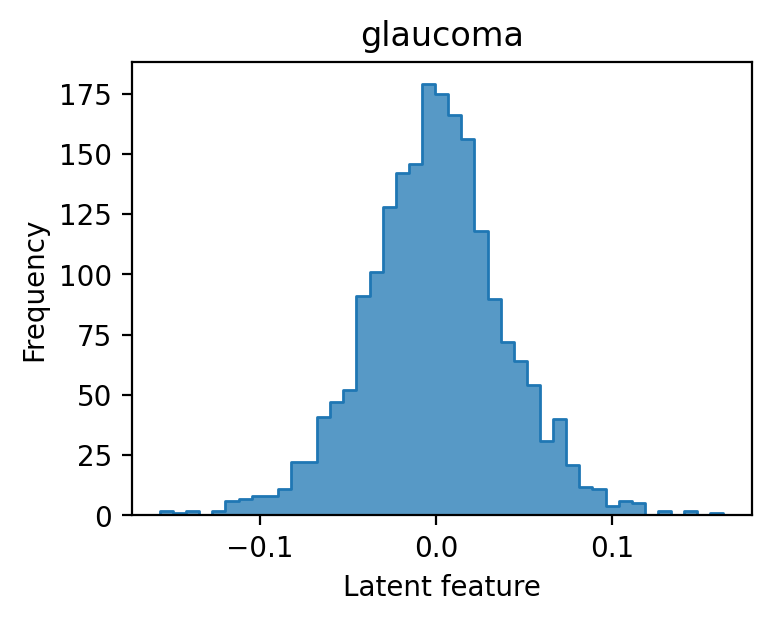

In [139]:
gethistogram(yd, lbl,0,kde = False)

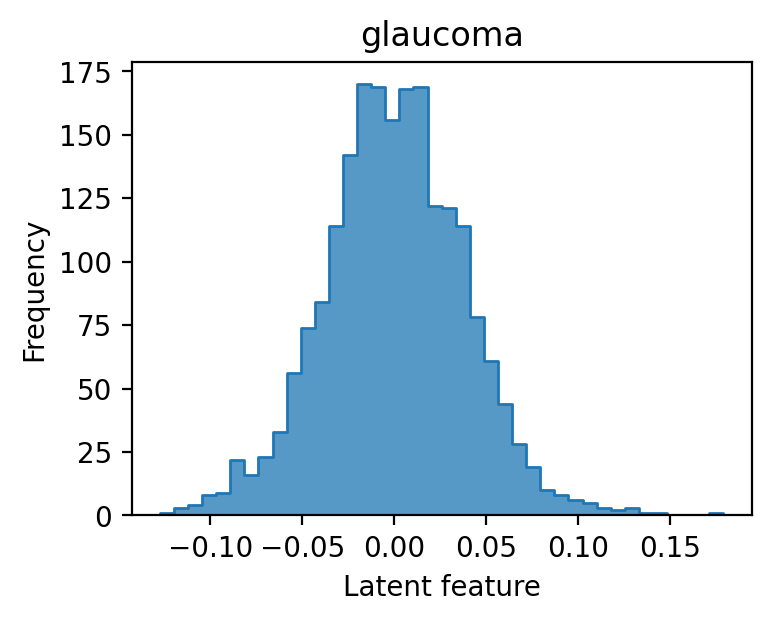

In [140]:
gethistogram(yd, lbl,1,kde = False)

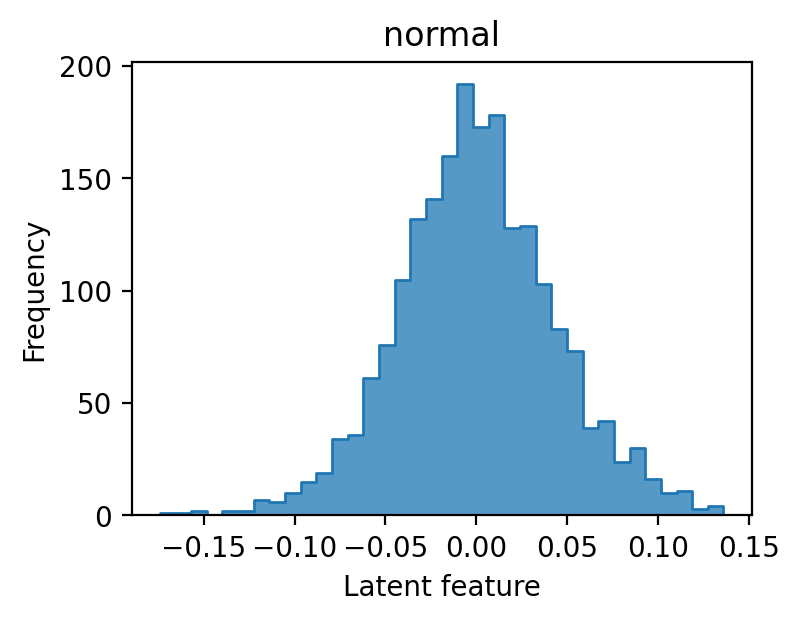

In [142]:
gethistogram(yd, lbl,3,kde = False)

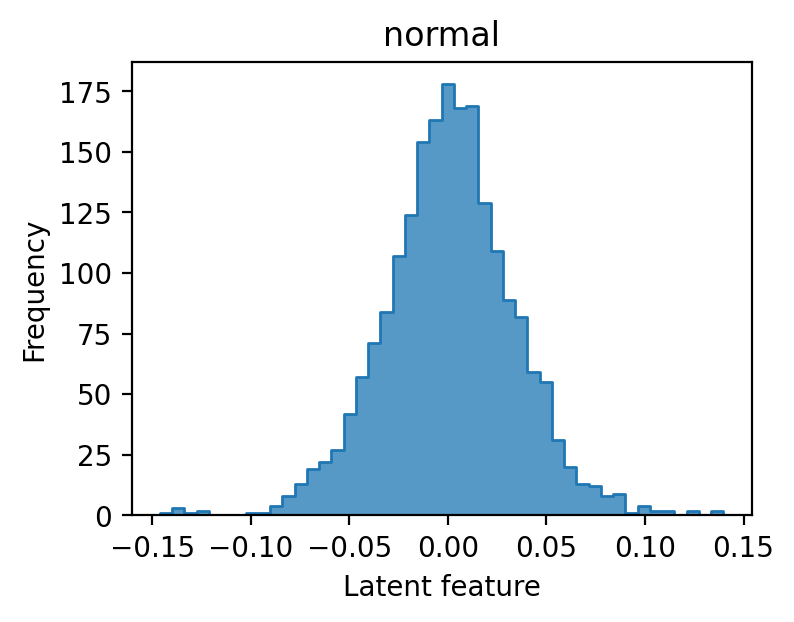

In [143]:
gethistogram(yd, lbl,4,kde = False)

In [4]:
#only on validation set
csv_path = '/home/vip/sayan-mandal/datasets/obj_criteria/20200619-objective.csv'
img_path = '/home/vip/sayan-mandal/datasets/obj_criteria/good_reduced/'

ResizeParam = 128
FD = FundusDataLoader(csv_path, img_path,transform=transforms.Compose([transforms.Resize(ResizeParam), transforms.RandomHorizontalFlip(p=0.5) ,transforms.ToTensor()]))
FD2 = FundusDataLoader(csv_path, img_path,transform=transforms.Compose([transforms.Resize(ResizeParam), transforms.ToTensor()]))

#random sampler
batch_size = 64
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(FD)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

#train_loader = torch.utils.data.DataLoader(FD, batch_size=batch_size, sampler=train_sampler)
data_loader = torch.utils.data.DataLoader(FD2, batch_size=batch_size, sampler=valid_sampler)


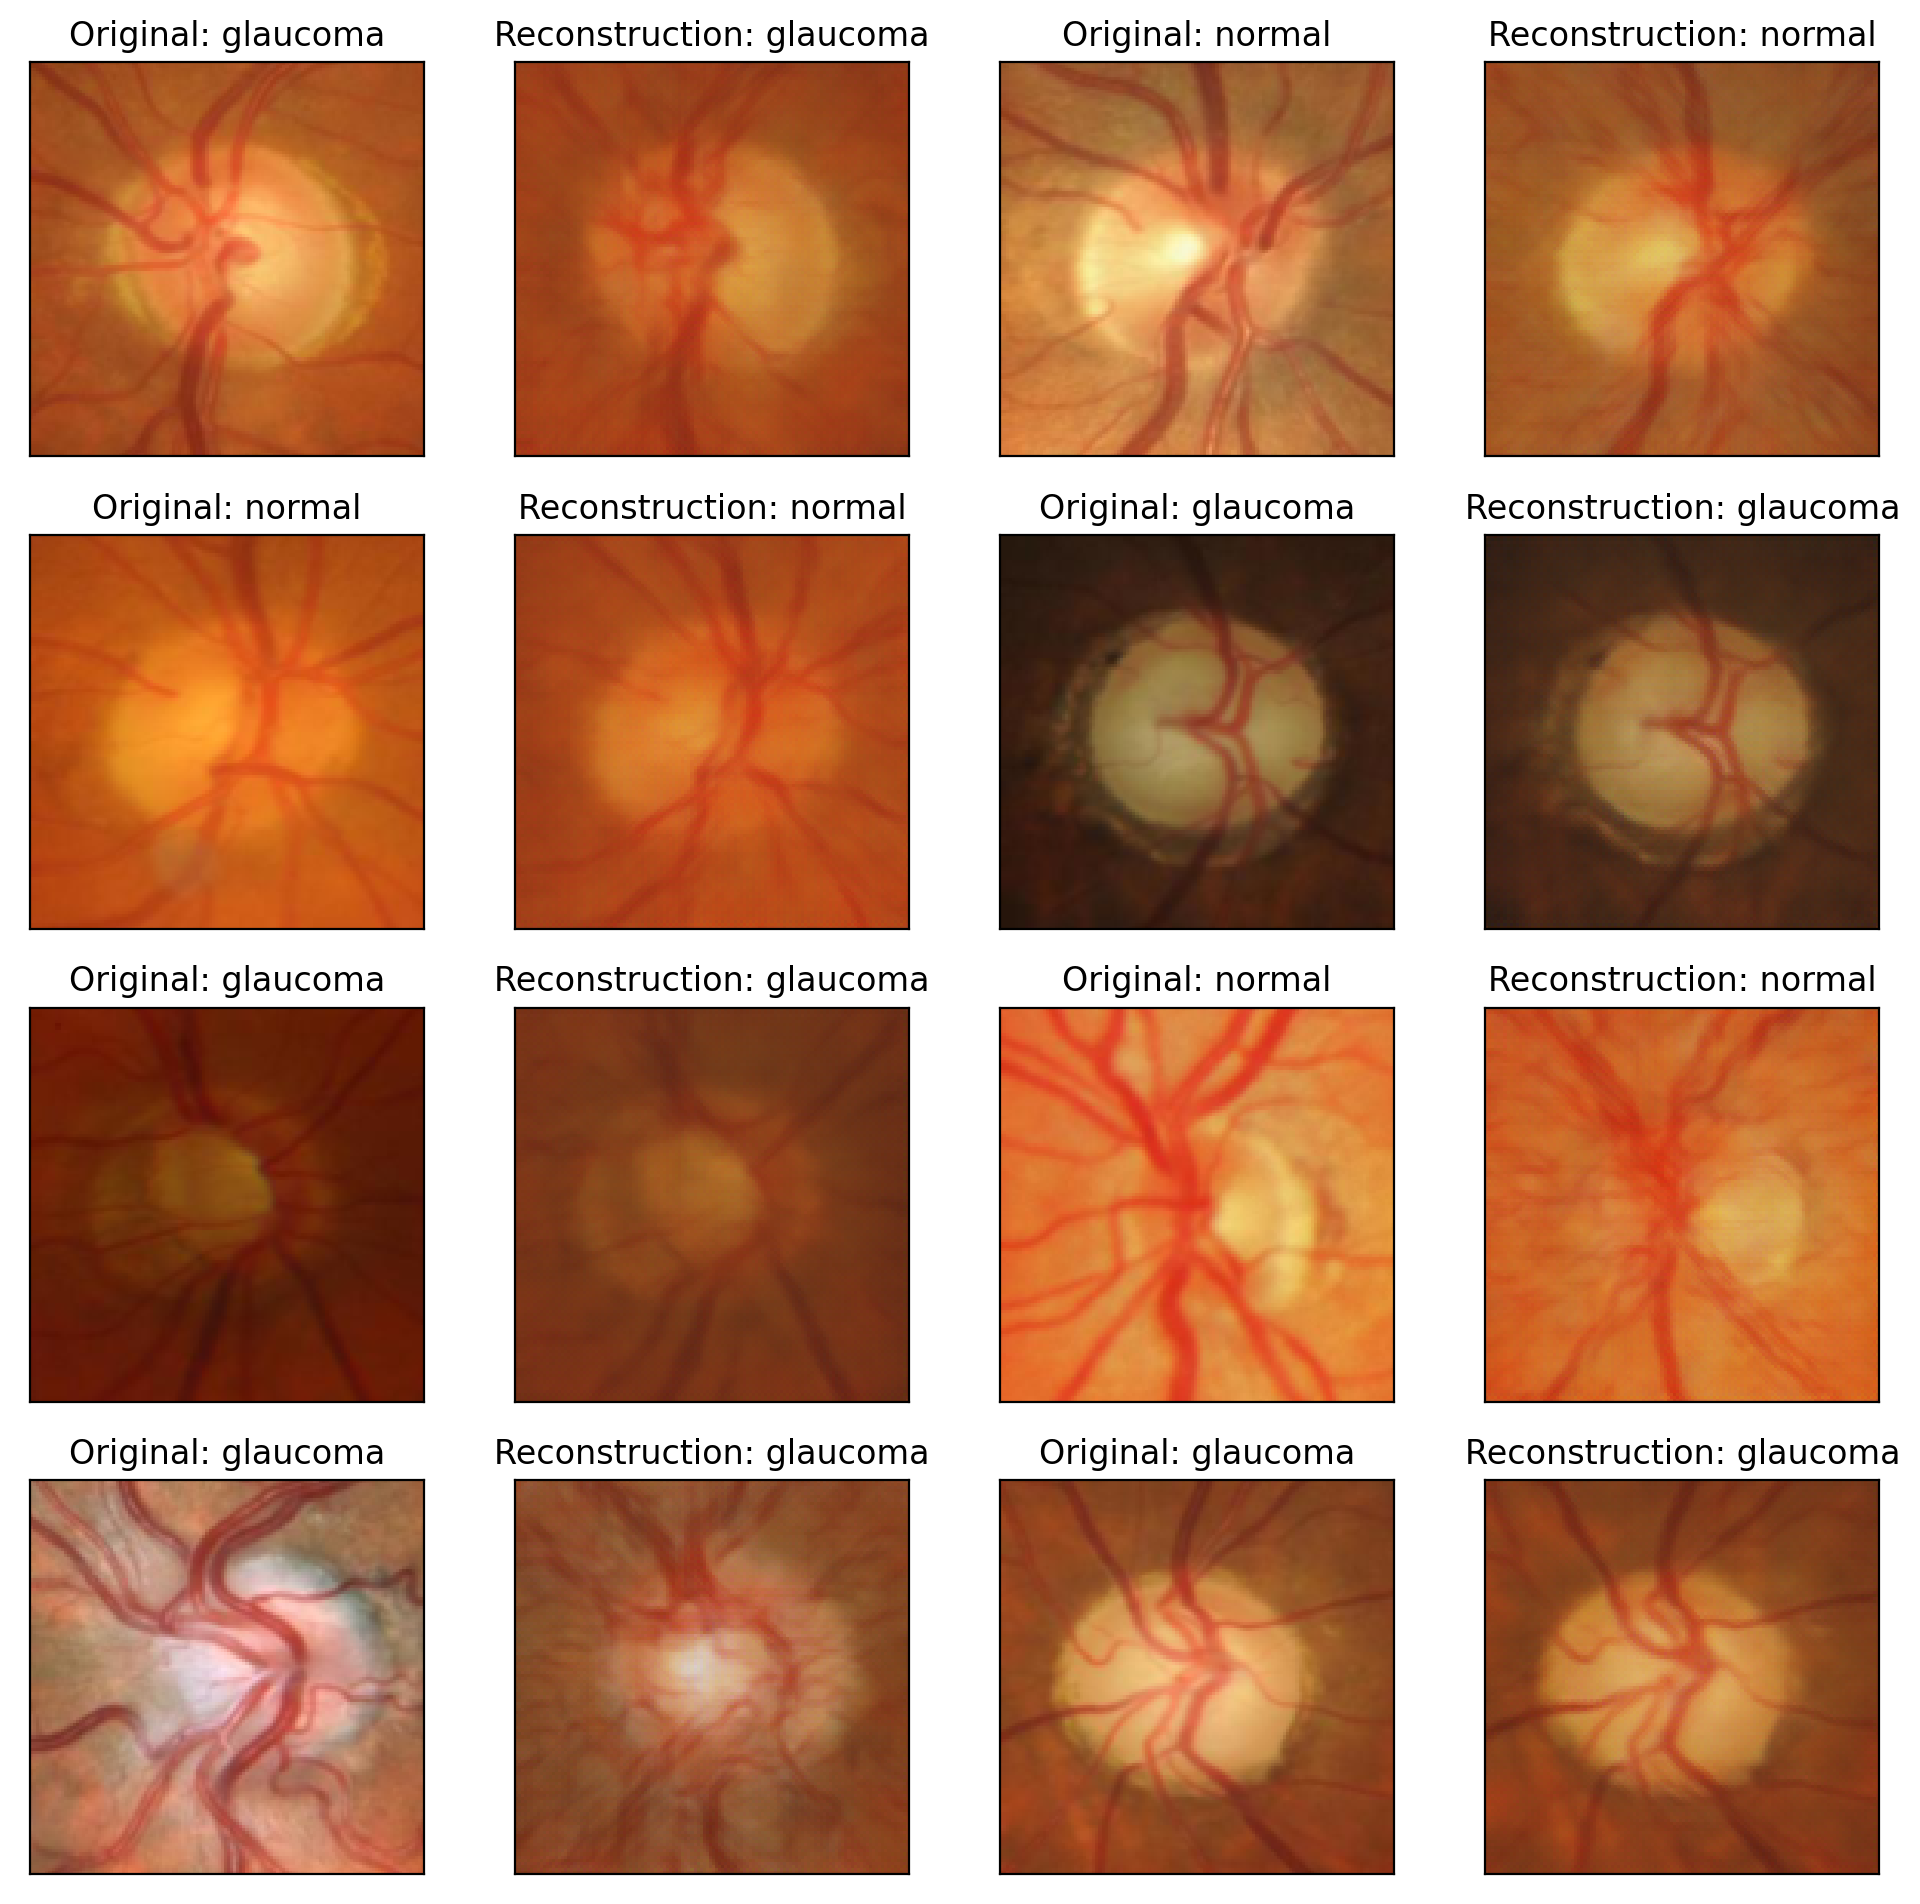

In [6]:
#Utility functions to un-normalize and display an image
def imshow(img):
    #img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0))) 

#Define the image classes
classes = ['normal','glaucoma']

#Obtain one batch of training images
dataiter = iter(data_loader)
data, labels = dataiter.next()
model.eval()
images,_,_ = model(Variable(data).cuda())
images = images.detach().cpu().numpy() # convert images to numpy for display

#Plot the images
fig = plt.figure(figsize=(12, 12))
# display 20 images
idx = 0
while idx < 16:
    ax = fig.add_subplot(4,4, idx+1, xticks=[], yticks=[])
    imshow(data[idx])
    ax.set_title("Original: " + classes[labels[idx]])
    idx+=1
    ax = fig.add_subplot(4,4, idx+1, xticks=[], yticks=[])
    imshow(images[idx-1])
    ax.set_title("Reconstruction: " + classes[labels[idx-1]])
    idx+=1


In [9]:
dataiter = iter(data_loader)
data, labels = dataiter.next()
model.eval()
images,_,_ = model(Variable(data).cuda())
images = images.detach().cpu().numpy() # convert images to numpy for display

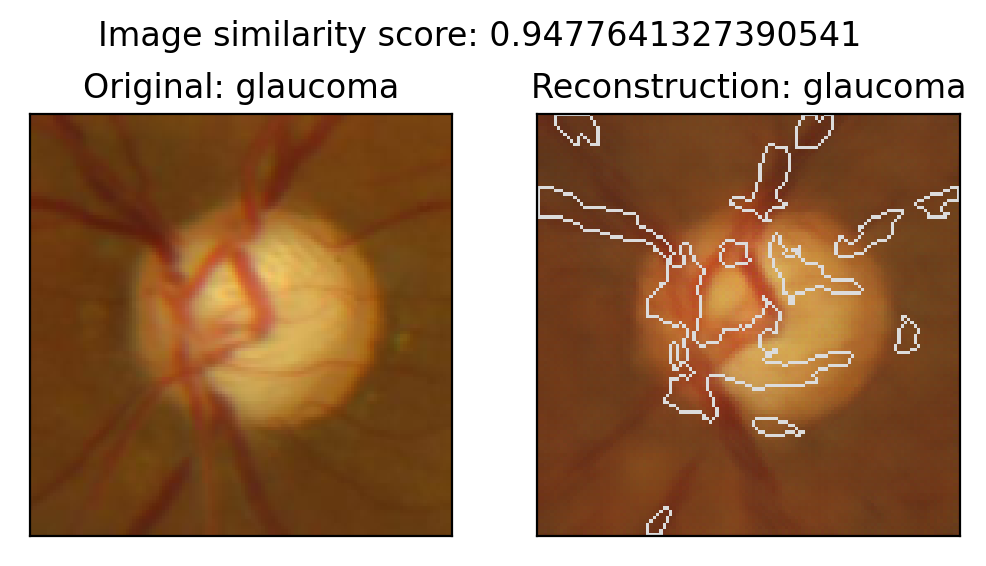

In [19]:
show_difference(idx = 7)

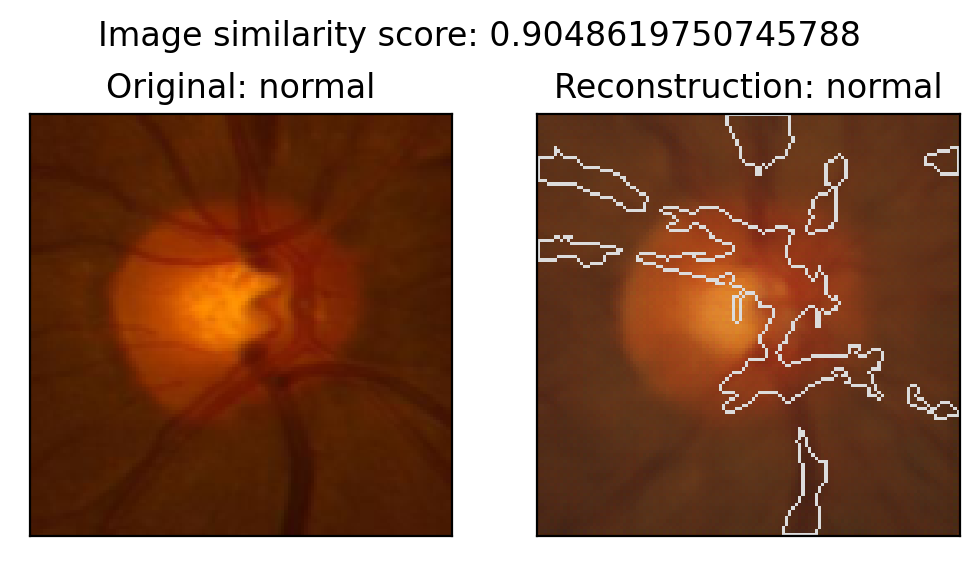

In [11]:
show_difference(idx=1)

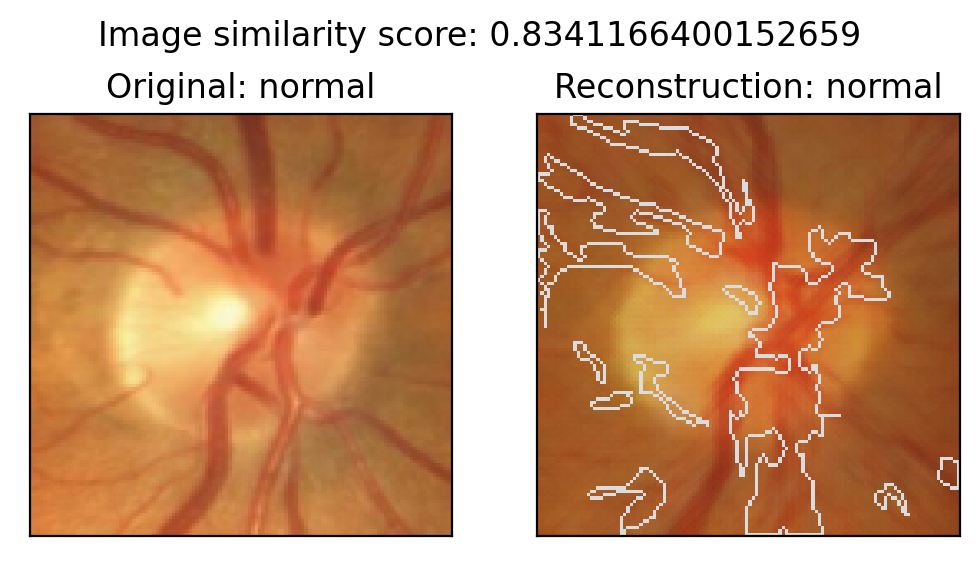

In [12]:
show_difference(idx=2)

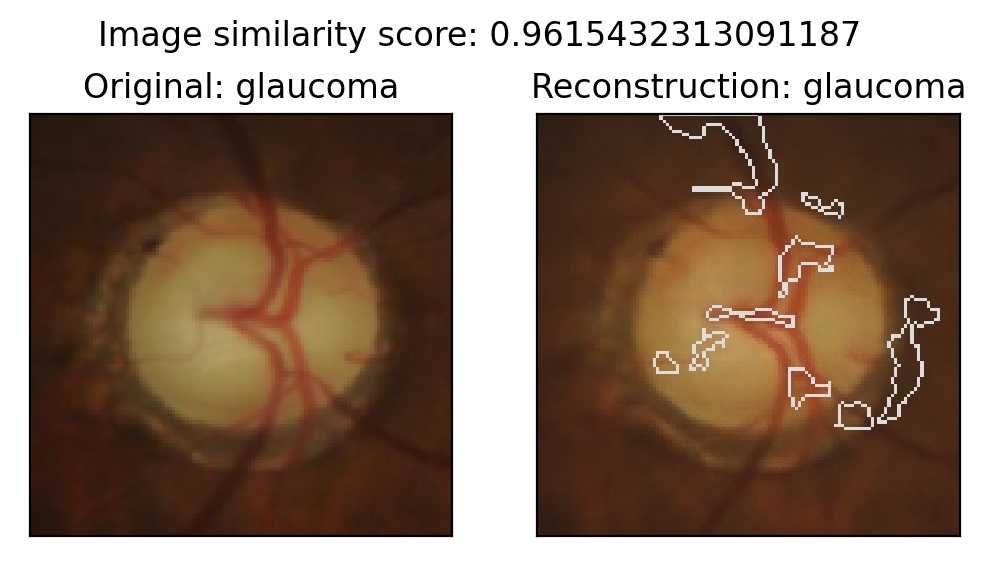

In [16]:
show_difference(idx=6)

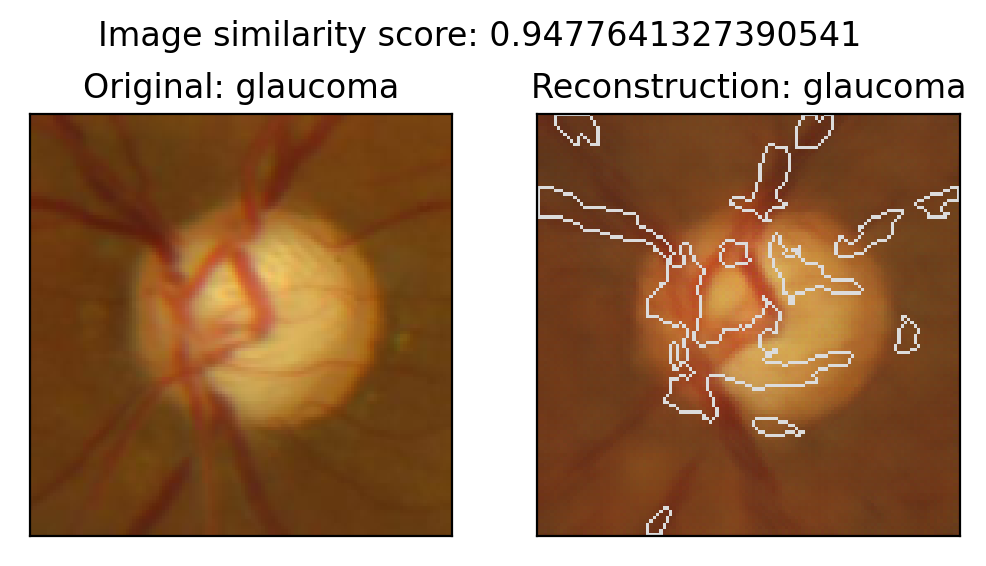

In [17]:
show_difference(idx=7)

In [5]:

for i, (data,label) in enumerate(data_loader):
    y, _,_ =  model.encode(Variable(data).cuda())
    y = y.cpu().detach().numpy()
    if i == 0:
        yd = y
        lbl = label.numpy()
    else:
        yd = np.append(yd,y,axis=0)
        lbl = np.append(lbl,label.numpy(), axis=0)

0
1


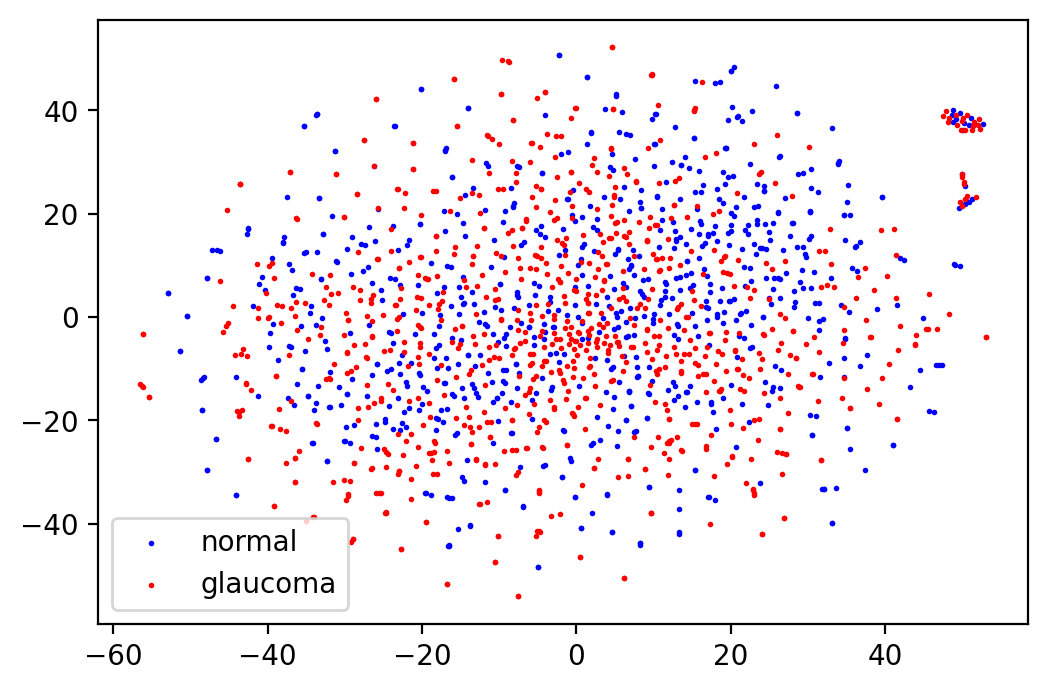

In [9]:
y_embed = TSNE(n_components=2).fit_transform(yd)
fig, ax = plt.subplots()
classes = ['normal','glaucoma']
cdict = {0: 'blue', 1: 'red'}
for g in np.unique(lbl):
    print(g)
    idx = np.where(lbl == g)
    ax.scatter(y_embed[idx,0],y_embed[idx,1],c=cdict[g], label = classes[g], s = 1, alpha = 1)
ax.legend()
plt.show()

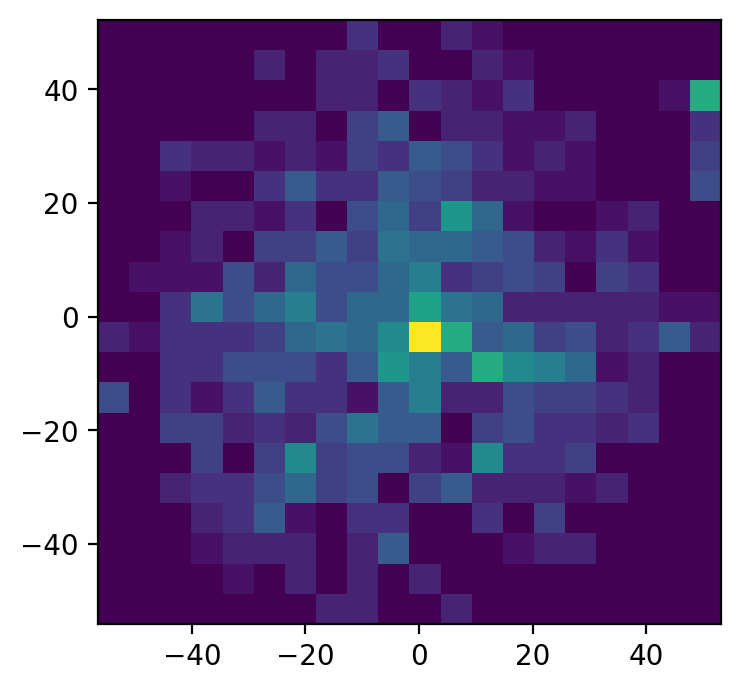

In [22]:
idx = np.where(lbl == 1)
heatmap, xedges, yedges = np.histogram2d(y_embed[idx,0].flatten(),y_embed[idx,1].flatten(),bins=20)
extent = [xedges[0],xedges[-1],yedges[0],yedges[-1]]
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

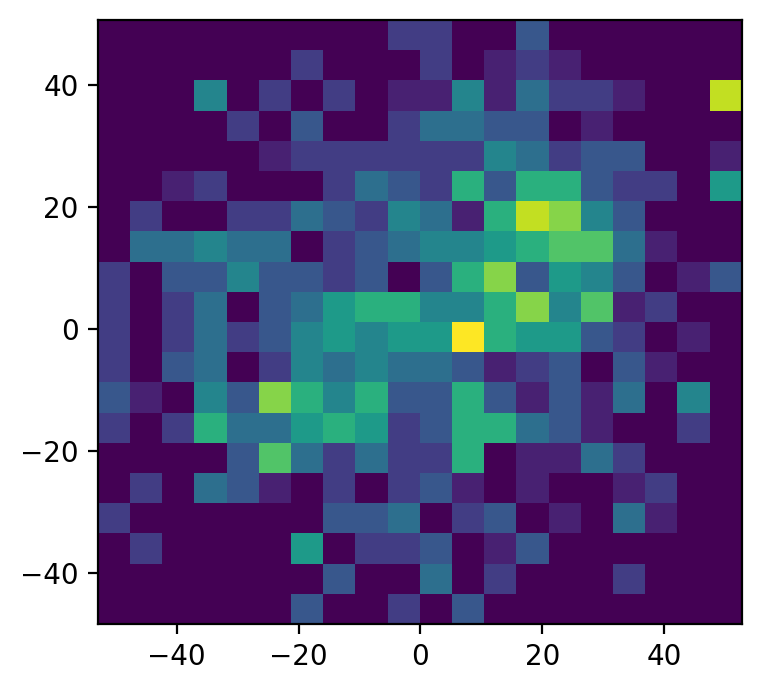

In [23]:
idx = np.where(lbl == 0)
heatmap, xedges, yedges = np.histogram2d(y_embed[idx,0].flatten(),y_embed[idx,1].flatten(),bins=20)
extent = [xedges[0],xedges[-1],yedges[0],yedges[-1]]
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()